# Step 2. Data Cleaning
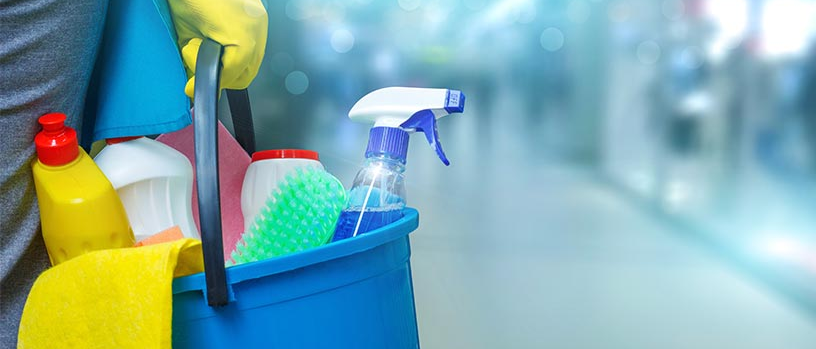

## TODO
- Big differences in 2017-218 vs 2016:
    - 0 182 
    - 0 102
- Lack of observations:
    - 1 1018 1 observation only
    - 0 740 0 observations (400micro only)


## Import libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)
from colorama import Fore

from utility import plot_timeseries

Load data from previous step:

In [2]:
datamart = pd.read_feather('./datasets/datamart.feather')
datamart.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62603520 entries, 0 to 62603519
Data columns (total 18 columns):
meter                 62603520 non-null uint8
building_id           62603520 non-null uint16
timestamp             62603520 non-null datetime64[ns]
fact                  20216100 non-null float64
row_id                41697600 non-null float64
site_id               62603520 non-null uint8
primary_use           62603520 non-null category
square_feet           62603520 non-null float32
year_built            25672704 non-null float32
floor_count           10889856 non-null float32
air_temperature       62261805 non-null float32
cloud_coverage        33861221 non-null float32
dew_temperature       62219377 non-null float32
precip_depth_1_hr     50749566 non-null float32
sea_level_pressure    58819365 non-null float32
wind_direction        58130731 non-null float32
wind_speed            62133224 non-null float32
leak                  16800125 non-null float64
dtypes: category(1

Add column for cleaned target:

In [3]:
datamart['target'] = np.nan

## Leaks vs fact

Show leak summary:

In [1]:
def show_leak_summary(datamart, leak_col='leak'):
    """Show percentage of rows with leak by meter type and site."""
    buildings = pd.DataFrame({'buildings': 
        datamart.groupby(['site_id', 'meter'])['building_id'].nunique()})
    buildings_with_leak = pd.DataFrame({'buildings with leak':
        datamart[datamart[leak_col] > 0].groupby(['site_id', 'meter'])['building_id'].nunique()})
    summary_table = buildings.merge(buildings_with_leak, how='left', left_index=True, right_index=True)
    summary_table['buildings with leak'] = summary_table['buildings with leak'].fillna(0).astype(int)
    summary_table['percent'] = summary_table['buildings with leak'] / summary_table['buildings']
    summary_table['percent'] = [f'{int(100 * val)}%' for val in summary_table['percent'].values]
    display(summary_table[summary_table['buildings with leak'] > 0])

show_leak_summary(datamart)    

Replace zero fact values with leaks:

In [5]:
index = (datamart['fact'] == 0) & (datamart['leak'] > 0)
print(f'{index.sum()} zero fact values were replaced')
datamart.loc[index, 'fact'] = datamart['leak']

631 zero fact values were replaced


Compute discrepancy between leak and fact data:

In [6]:
def compute_leak_discrepancy(datamart, fact_col='fact', leak_col='leak',
                             group_cols=['meter', 'site_id', 'building_id'],
                             ignore_zero_values=False):
    if ignore_zero_values:
        nonnan_index = (datamart[fact_col] > 0) & (datamart[leak_col] > 0)
    else:
        nonnan_index = (~datamart[fact_col].isna()) & (~datamart[leak_col].isna())
    datamart = datamart.loc[nonnan_index, group_cols + [fact_col, leak_col]]
    datamart['diff_abs'] = abs(datamart[fact_col] - datamart[leak_col])
    datamart['diff_rel'] = datamart['diff_abs'] / datamart[[fact_col, leak_col]].max(axis=1).clip(lower=1)
    summary_table = datamart.groupby(group_cols)['diff_abs', 'diff_rel'].mean()
    summary_table.sort_values(by='diff_rel', ascending=False, inplace=True)
    return summary_table[summary_table['diff_rel'] > 0.001]

leak_discr = compute_leak_discrepancy(datamart, ignore_zero_values=False)
display(leak_discr)

diff_abs  diff_rel
meter site_id building_id                     
0     4       639           0.675312  0.095877
              565           0.770726  0.076299
              596           0.567064  0.063670
              591           1.141234  0.060378
              650           5.297680  0.057890
              613           0.064559  0.056967
              579           0.074484  0.053429
              601           0.679912  0.048612
              642           0.598447  0.047477
              616           2.673011  0.041320
              607           0.901091  0.039329
              646           1.529551  0.038897
              571           1.266616  0.037666
              566           0.036290  0.033260
              610           1.072185  0.028974
              605           0.655767  0.027926
              623           0.622395  0.027565
              628           0.558690  0.025927
              588           0.431502  0.025629
              600           1.490730  0.021365
              583          10.971325  0.021191
              586           1.892310  0.021114
              612           1.772781  0.019834
              597           2.521376  0.019754
              640           5.076971  0.019490
              630           1.000526  0.019467
              575           0.642136  0.018889
              574           0.539994  0.018647
              643           1.579950  0.017347
              622           3.356155  0.015900
              654           0.825369  0.015779
              569           5.318827  0.015393
              580           1.423126  0.015278
              655           2.179175  0.015188
              589           1.791812  0.014483
              619           2.591390  0.014064
              627           1.449112  0.012886
              598           0.662461  0.012791
              614           2.355642  0.012559
              595           2.639581  0.012317
              632           0.665871  0.011150
              621           0.174122  0.010013
              599           0.894895  0.009502
              584           1.281070  0.009398
              585           2.000365  0.009246
              641           4.047305  0.008761
              626           1.003247  0.008666
              624           0.751769  0.007975
              573           0.107662  0.007605
              587           0.744993  0.007299
              653           6.502100  0.006838
              594           2.411969  0.006254
              644           1.638134  0.006106
              617           3.612370  0.005736
              602           2.702333  0.005607
              568           0.023724  0.004653
              652           0.388245  0.004195
              609           1.997672  0.003965
              636           0.003471  0.003471
              634           0.003452  0.003452
              637           0.003430  0.003430
              604           0.004419  0.002687
              649           1.191861  0.002473
              638           0.005054  0.001553
              611           0.743980  0.001426
              577           0.001435  0.001340
              635           0.004157  0.001218
              631           0.011434  0.001044
              592           0.404357  0.001005

Plot rows with biggest discrepancy:

In [7]:
#plot_timeseries(datamart, rows_df=leak_discr)

Calculate first fact and leak dates per row:

In [8]:
eps = 0.001
first_fact = datamart[datamart['fact'] > eps].groupby(['meter', 'building_id'])['timestamp'].min().reset_index()
first_fact.rename(columns={'timestamp': 'first_fact'}, inplace=True)
first_leak = datamart[datamart['leak'] > eps].groupby(['meter', 'building_id'])['timestamp'].min().reset_index()
first_leak.rename(columns={'timestamp': 'first_leak'}, inplace=True)

df = first_fact.merge(first_leak, on=['meter', 'building_id'])
display(df[df['first_leak'] < df['first_fact']])

meter  building_id          first_fact          first_leak
311      0          591 2016-09-02 09:00:00 2016-05-04 09:00:00
323      0          604 2016-11-21 16:00:00 2016-10-16 18:00:00

Correct first fact date for meter 0 for buildings at site 0:

In [9]:
all_rows = datamart[['meter', 'building_id']].drop_duplicates()
first_fact = first_fact.merge(all_rows, how='right')
first_fact.loc[(first_fact['meter'] == 0) & (first_fact['building_id'] <= 104), 'first_fact'] = (
    first_fact['first_fact'].clip(lower=pd.Timestamp('05.21.2016'), axis=0))
first_fact['first_fact'].fillna(pd.Timestamp('01.01.2017'), inplace=True)
display(first_fact)

meter  building_id          first_fact
0         0            0 2016-05-21 00:00:00
1         0            1 2016-05-21 00:00:00
2         0            2 2016-05-21 00:00:00
3         0            3 2016-05-21 00:00:00
4         0            4 2016-05-21 00:00:00
...     ...          ...                 ...
2375      3         1323 2016-01-01 00:00:00
2376      3         1324 2016-01-04 13:00:00
2377      3         1325 2016-01-01 00:00:00
2378      3         1331 2016-01-01 00:00:00
2379      0          740 2017-01-01 00:00:00

[2380 rows x 3 columns]

Drop period of time before first positive meter reading:

In [10]:
datamart = datamart.merge(first_fact, how='left', on=['meter', 'building_id'])
datamart = datamart[datamart['timestamp'] >= datamart['first_fact']].drop('first_fact', axis=1).reset_index(drop=True)

Combine fact and leak into single variable **_target_**:

In [11]:
fact_index = (~datamart['fact'].isna())
leak_index = (datamart['fact'].isna()) & (~datamart['leak'].isna())
datamart.loc[fact_index, 'target'] = datamart['fact']
datamart.loc[leak_index, 'target'] = datamart['leak']

## Detect outliers

#### 1. Check for negative meter readings.
Make sure that there are no negative values in signals.

In [12]:
def compute_negatives_count(datamart, target_col='target', group_cols=['meter', 'site_id', 'building_id']):
    datamart = datamart.loc[:, group_cols + [target_col]]
    datamart['negatives_count'] = datamart[target_col] < 0
    summary_table = datamart.groupby(group_cols)['negatives_count'].sum().reset_index()
    summary_table.sort_values(by=['negatives_count'], ascending=False, inplace=True)
    return summary_table[summary_table['negatives_count'] > 0]

negatives_count = compute_negatives_count(datamart)
print(f"Count of target negative values = {negatives_count['negatives_count'].sum()}")
display(negatives_count)

Count of target negative values = 0


Empty DataFrame
Columns: [meter, site_id, building_id, negatives_count]
Index: []

#### 2. Check for extreme big meter readings.
Compare each value to median of positive values of that row.

In [13]:
# Save
datamart_copy = datamart.copy()

In [14]:
# Load
datamart = datamart_copy.copy()

def detect_big_outliers(datamart, coef=115, target_col='target', group_cols=['meter', 'site_id', 'building_id']):
    datamart = datamart.loc[:, group_cols + [target_col]]
    thresholds = datamart[datamart[target_col] > 0].groupby(group_cols).mean().reset_index()
    thresholds.rename(columns={target_col: 'threshold'}, inplace=True)
    datamart = datamart.merge(thresholds, how='left', on=group_cols)
    datamart['outliers'] = (datamart[target_col] > coef*datamart['threshold'])
    summary_table = datamart.groupby(group_cols)['outliers'].sum().reset_index()
    summary_table.sort_values(by='outliers', ascending=False, inplace=True)
    return summary_table[summary_table['outliers'] > 0], datamart['outliers'].values
    
big_outliers_summary, big_outliers_index = detect_big_outliers(datamart)
datamart.loc[big_outliers_index, 'target'] = np.nan
display(big_outliers_summary)

meter  site_id  building_id  outliers
1422      1        0           43       3.0
1415      1        0           13       2.0
78        0        0           78       1.0
1673      1       10         1017       1.0
1947      2        9          876       1.0

In [15]:
#plot_timeseries(datamart, rows_df=big_outliers_summary)

Check remaining big meter readings:

In [16]:
def compute_max_values(datamart, target_col='target', group_cols=['meter', 'site_id', 'building_id']):
    datamart = datamart.loc[:, group_cols + [target_col]]
    summary_table = datamart.groupby(group_cols).max().reset_index()
    summary_table.rename(columns={target_col: 'max target'}, inplace=True)
    summary_table.sort_values(by='max target', ascending=False, inplace=True)
    return summary_table
    
max_values = compute_max_values(datamart)
display(max_values)

meter  site_id  building_id    max target
2054      2       13         1099  2.190470e+07
1553      1        6          778  8.803740e+05
1691      1       13         1088  3.566400e+05
1662      1        9          993  2.999640e+05
1630      1        9          954  2.749940e+05
...     ...      ...          ...           ...
804       0        8          815  8.333000e-01
2138      2       14         1259  7.438000e-01
1671      1       10         1013  5.980000e-02
1674      1       10         1018  3.340000e-02
740       0        5          740           NaN

[2380 rows x 4 columns]

In [17]:
#plot_timeseries(datamart, rows_df=max_values.head(20))

#### 3. Detect periods with constant values.
The idea is to use moving std in window of small width and compare it to zero.  
For hot water (meter 3) filtration is disabled at all due to signal discrete pattern, and for cold water and steam (meters 1 and 2) it's disabled only for zero periods due to seasonality.

In [18]:
# Save
datamart_copy = datamart.copy()

In [19]:
# Load
datamart = datamart_copy.copy()
datamart.sort_values(by=['meter', 'site_id', 'building_id'], inplace=True)

def detect_constant_periods(datamart, window=5*24-1, target_col='target', 
                            group_cols=['meter', 'site_id', 'building_id']):
    datamart = datamart.loc[:, group_cols + [target_col]]
    datamart['std'] = datamart.groupby(group_cols)[target_col].rolling(window, center=True).std()\
        .rolling(window-2, center=True).min().values
    eps = 0.0001
    datamart['outliers'] = ((datamart['std'] < eps) & (datamart['meter'] != 3)
                            & ((datamart[target_col] > 0) | (datamart['meter'] == 0)))
    summary_table = datamart.groupby(group_cols)['outliers'].sum().reset_index()
    summary_table.sort_values(by='outliers', ascending=False, inplace=True)
    return summary_table[summary_table['outliers'] > 0], datamart['outliers'].values
    
constant_periods_summary, constant_periods_index = detect_constant_periods(datamart)
datamart.loc[constant_periods_index, 'target'] = np.nan
display(constant_periods_summary.head(10))

meter  site_id  building_id  outliers
1318      0       15         1345   11271.0
117       0        1          117   10028.0
22        0        0           22    9274.0
106       0        1          106    8169.0
102       0        0          102    8146.0
1201      0       14         1227    8023.0
218       0        2          218    7636.0
180       0        2          180    7595.0
110       0        1          110    7490.0
1288      0       14         1314    7074.0

In [20]:
# Test section
window = 5*24-1
datamart_t = datamart_copy.copy()
datamart_t = datamart_t[(datamart_t['meter'] == 0) & (datamart_t['building_id'] == 1402)]
group_cols=['meter', 'site_id', 'building_id']
target_col = 'target'
datamart_t = datamart_t.loc[:, group_cols + ['timestamp', target_col]]
datamart_t['std'] = datamart_t.groupby(group_cols)[target_col].rolling(window, center=True).std()\
        .rolling(window-2, center=True).min().values
eps = 0.0001
datamart_t['outliers'] = ((datamart_t['std'] < eps) & (datamart_t['meter'] != 3)
                            & ((datamart_t[target_col] > 0) | (datamart_t['meter'] == 0)))
#datamart_t[(datamart_t['timestamp'] >= '09.01.2018') & (datamart_t['timestamp'] <= '09.13.2018')]

In [21]:
#plot_timeseries(datamart, rows_df=constant_periods_summary.head(200))

#### 4. Check for zero meter readings.
If signal has a lot of zero values, it's probably feature, otherwise outliers.  
This filtration is enabled only for electricity (meter 0).

In [22]:
# Save
datamart_copy = datamart.copy()

In [23]:
# Load
datamart = datamart_copy.copy()

def detect_zero_outliers(datamart, zeros_count_threshold=30, target_col='target', 
                         group_cols=['meter', 'site_id', 'building_id']):
    datamart = datamart.loc[:, group_cols + [target_col]]
    datamart['zero'] = (datamart[target_col] == 0) & (datamart['meter'] == 0)
    zeros_count = datamart.groupby(group_cols)['zero'].sum().reset_index()
    zeros_count.rename(columns={'zero': 'zeros_count'}, inplace=True)
    datamart = datamart.merge(zeros_count, how='left', on=group_cols)
    datamart['outliers'] = (datamart['zero']) & (datamart['zeros_count'] < zeros_count_threshold)
    summary_table = datamart.groupby(group_cols)['outliers', 'zero'].sum().reset_index()
    summary_table.sort_values(by='outliers', ascending=False, inplace=True)
    return summary_table, datamart['outliers'].values

zero_outliers_summary, zero_outliers_index = detect_zero_outliers(datamart)
datamart.loc[zero_outliers_index, 'target'] = np.nan
display(zero_outliers_summary.head(10))

meter  site_id  building_id  outliers  zero
720       0        5          720      29.0  29.0
257       0        2          257      28.0  28.0
42        0        0           42      28.0  28.0
227       0        2          227      28.0  28.0
1218      0       14         1244      27.0  27.0
200       0        2          200      27.0  27.0
1093      0       13         1110      26.0  26.0
226       0        2          226      26.0  26.0
665       0        5          665      26.0  26.0
197       0        2          197      25.0  25.0

In [24]:
#plot_timeseries(datamart, rows_df=zero_outliers_summary[zero_outliers_summary['site_id'] == 15])

In [25]:
#plot_timeseries(datamart, rows_df=zero_outliers_summary.head(20))

In [26]:
zero_outliers_summary['zero'].sort_values(ascending=False).reset_index(drop=True).iplot(
    asFigure=True, kind='scatter', width=1, theme='white', title='Zeros count per row',
    #dimensions=(None, None), margin=(0, 0, 30, 30),
)

In [27]:
datamart

meter  building_id           timestamp     fact      row_id  \
0             0            0 2016-05-21 00:00:00  249.817         NaN   
1             0            0 2016-05-21 01:00:00  246.404         NaN   
2             0            0 2016-05-21 02:00:00  247.087         NaN   
3             0            0 2016-05-21 03:00:00  252.547         NaN   
4             0            0 2016-05-21 04:00:00  244.357         NaN   
...         ...          ...                 ...      ...         ...   
61802455      3         1331 2018-12-31 19:00:00      NaN  41497337.0   
61802456      3         1331 2018-12-31 20:00:00      NaN  41497587.0   
61802457      3         1331 2018-12-31 21:00:00      NaN  41497837.0   
61802458      3         1331 2018-12-31 22:00:00      NaN  41498087.0   
61802459      3         1331 2018-12-31 23:00:00      NaN  41498337.0   

          site_id primary_use  square_feet  year_built  floor_count  \
0               0   Education       7432.0      2008.0          NaN   
1               0   Education       7432.0      2008.0          NaN   
2               0   Education       7432.0      2008.0          NaN   
3               0   Education       7432.0      2008.0          NaN   
4               0   Education       7432.0      2008.0          NaN   
...           ...         ...          ...         ...          ...   
61802455       15   Education     171008.0      1930.0          NaN   
61802456       15   Education     171008.0      1930.0          NaN   
61802457       15   Education     171008.0      1930.0          NaN   
61802458       15   Education     171008.0      1930.0          NaN   
61802459       15   Education     171008.0      1930.0          NaN   

          air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
0               23.900000             NaN             20.6                0.0   
1               23.299999             8.0             20.6               -1.0   
2               22.799999             NaN             21.1                5.0   
3               22.799999             NaN             21.1                0.0   
4               22.799999             NaN             21.1                0.0   
...                   ...             ...              ...                ...   
61802455              NaN             NaN              NaN                NaN   
61802456              NaN             NaN              NaN                NaN   
61802457              NaN             NaN              NaN                NaN   
61802458              NaN             NaN              NaN                NaN   
61802459              NaN             NaN              NaN                NaN   

          sea_level_pressure  wind_direction  wind_speed        leak   target  
0                1018.200012           310.0         4.1  249.817039  249.817  
1                1017.700012           250.0         1.5  246.404238  246.404  
2                1015.099976           150.0         5.1  247.086794  247.087  
3                1015.000000           180.0         2.1  252.547283  252.547  
4                1015.099976             0.0         0.0  244.356549  244.357  
...                      ...             ...         ...         ...      ...  
61802455                 NaN             NaN         NaN         NaN      NaN  
61802456                 NaN             NaN         NaN         NaN      NaN  
61802457                 NaN             NaN         NaN         NaN      NaN  
61802458                 NaN             NaN         NaN         NaN      NaN  
61802459                 NaN             NaN         NaN         NaN      NaN  

[61802460 rows x 19 columns]

## Results of cleaning

In [28]:
results = datamart[((~datamart['fact'].isna()) | (~datamart['leak'].isna())) & (datamart['target'].isna())]\
    .groupby(['meter', 'site_id', 'building_id'])['timestamp'].count().reset_index()\
    .rename(columns={'timestamp': 'filtered'}).sort_values(by='filtered', ascending=False)
display(results.head(10))

meter  site_id  building_id  filtered
531      0       15         1345     11271
111      0        1          117     10028
22       0        0           22      9274
101      0        1          106      8170
97       0        0          102      8146
489      0       14         1227      8023
183      0        2          218      7636
151      0        2          180      7595
105      0        1          110      7490
524      0       14         1314      7074

In [29]:
#plot_timeseries(datamart, rows_df=results.head(10))

In [30]:
#plot_timeseries(datamart)

## Save results
Export to feather:

In [31]:
datamart.to_feather('./datasets/datamart_cleaned.feather')

## Notes